
DixonPrice: 3D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=0f10823165baa553dd9b0bb8c1e1e06df89fc00b51c9a135b259919e7e4327e9
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'DixonPrice'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 30
opt = True

In [4]:
### Objective Function - DixonPrice(x) 3-D:

def objfunc(x1_training, x2_training, x3_training):
            return  operator * ((x1_training - 1)**2
                            + 2 * (2 * x2_training ** 2 - x1_training)**2
                            + 3 * (2 * x3_training ** 2 - x2_training)**2      
                           )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 3

# 3-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub]),
                'x3_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x3_test = np.linspace(lb, ub, n_test)
Xstar = np.column_stack((x1_test, x2_test, x3_test))


In [5]:
n_start_AcqFunc = iters #multi-start iterations to avoid local optima in AcqFunc optimization


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [10]:
## dGPGO:

grad = 0

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1631274356.2880228

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125 ]. 	  -117949.69994259246 	 -1743.4541121077734
init   	 [-3.95334855 -7.06488218 -8.1532281 ]. 	  -80377.19459880023 	 -1743.4541121077734
init   	 [-6.27479577 -3.08878546 -2.06465052]. 	  -1743.4541121077734 	 -1743.4541121077734
init   	 [ 0.77633468 -1.61610971  3.70439001]. 	  -2573.2528931184784 	 -1743.4541121077734
init   	 [-5.91095501  7.56234873 -9.45224814]. 	  -116840.74897847573 	 -1743.4541121077734
1      	 [-8.03306332 -1.5778475   9.1577906 ]. 	  -86415.93772353831 	 -1743.4541121077734
2      	 [-5.34051452  6.14210391 -2.24278712]. 	  -13140.755438034004 	 -1743.4541121077734
3      	 [ 8.37203556 -9.9919595   9.53518298]. 	  -183648.52554820437 	 -1743.4541121077734
4      	 [ 4.63457201 -4.80603213 -4.85861402]. 	  -11585.604670094763 	 -1743.4541121077734
5      	 [-3.51458507  8.6139047   6.52216403]. 	  -63715.6072154213 	 -1743.4541121077734
6      	 [10. 10

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956]. 	  -65976.47275174354 	 -579.2546019074869
init   	 [-1.29355215 -1.59264396 -3.39330358]. 	  -1905.0058741906205 	 -579.2546019074869
init   	 [-5.90702732  2.38541933 -4.00690653]. 	  -3296.179887891325 	 -579.2546019074869
init   	 [-4.6634545   2.42267666  0.58284189]. 	  -579.2546019074869 	 -579.2546019074869
init   	 [-7.30840109  0.27156243 -6.31120269]. 	  -19089.001096649215 	 -579.2546019074869
1      	 [ 6.17490222 10.         10.        ]. 	  -183463.116669407 	 -579.2546019074869
2      	 [0.98993642 6.90226231 9.77019402]. 	  -119362.43308455861 	 -579.2546019074869
3      	 [ 9.60970158 -5.07492822  5.80487605]. 	  -19340.238894145325 	 -579.2546019074869
4      	 [ 2.89052379 -3.76941193  7.60597912]. 	  -44126.90703116023 	 -579.2546019074869
5      	 [9.47735243 3.96398709 2.5157724 ]. 	  -1262.1549087902345 	 -579.2546019074869
6      	 [ 8.77937768 -3.87353549 

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522]. 	  -5112.352385443115 	 -5112.352385443115
init   	 [0.2165521  7.85893909 7.92586178]. 	  -72027.10255913956 	 -5112.352385443115
init   	 [-7.48829379 -5.85514244 -8.97065593]. 	  -95107.57411907075 	 -5112.352385443115
init   	 [-1.18380313 -9.40247578 -0.86333551]. 	  -63726.548838065995 	 -5112.352385443115
init   	 [ 2.98288095 -4.43025435  3.52509804]. 	  -5207.626899787465 	 -5112.352385443115
1      	 [9.51990845 3.44767352 8.05668217]. 	  -48388.97288671367 	 -5112.352385443115
2      	 [-4.79309855  3.83955024  7.91140656]. 	  -46554.468417027776 	 -5112.352385443115
3      	 [ 4.12112367 -8.76918568 -4.10613003]. 	  -50231.76564197207 	 -5112.352385443115
4      	 [ 1.06865668 -1.61214113  9.66323576]. 	  -106482.0605763776 	 -5112.352385443115
5      	 [-8.59761974  6.46090428 -2.16585045]. 	  -17076.70485896509 	 -5112.352385443115
6      	 [ 8.83706845 -0.31089701 -6

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872 ]. 	  -95022.01065457039 	 -12458.30178377884
init   	 [ 4.29631987  3.95457649 -5.67821009]. 	  -12458.30178377884 	 -12458.30178377884
init   	 [ 9.5254891  -9.8753949  -4.94035275]. 	  -79242.42901009263 	 -12458.30178377884
init   	 [-1.30416935  5.58765844 -6.04629851]. 	  -21812.938480423 	 -12458.30178377884
init   	 [ 7.25986471  9.66801354 -6.72315517]. 	  -84163.5372919417 	 -12458.30178377884
1      	 [-7.83613234 -6.83553186  0.90405303]. 	  -20810.660474524404 	 -12458.30178377884
2      	 [ 2.6338449  -4.23926346 -1.84756645]. 	  -2589.0171533153275 	 -2589.0171533153275
3      	 [-1.92379477  1.34737929  2.7226803 ]. 	  -615.2747034779208 	 -615.2747034779208
4      	 [ 10. -10.  10.]. 	  -204581.0 	 -615.2747034779208
5      	 [-5.27132412 -9.28238298 10.        ]. 	  -194517.77575203 	 -615.2747034779208
6      	 [9.81335626 8.39300429 2.56386853]. 	  -34505.04579158221 

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689]. 	  -38038.55423396639 	 -504.37713268919686
init   	 [ 8.37221816 -0.23177622  2.23487726]. 	  -504.37713268919686 	 -504.37713268919686
init   	 [ 5.31815713  0.36835976 -4.06398997]. 	  -3270.33229475548 	 -504.37713268919686
init   	 [-6.24557543 -8.38517462  4.76880592]. 	  -51898.195262717614 	 -504.37713268919686
init   	 [-1.17381554 -6.83380265  7.59874062]. 	  -62777.04813872957 	 -504.37713268919686
1      	 [ 5.59029171 -9.54133815  1.55325716]. 	  -62933.45175267557 	 -504.37713268919686
2      	 [-3.94963775  6.51411653  3.18834561]. 	  -16374.16808563396 	 -504.37713268919686
3      	 [ 10. -10.  10.]. 	  -204581.0 	 -504.37713268919686
4      	 [ 3.14692525  9.50918422 -2.23413701]. 	  -63161.457005708806 	 -504.37713268919686
5      	 [ 4.56139684 -4.673529    0.23379905]. 	  -3142.4271112122515 	 -504.37713268919686
6      	 [-8.35759819 -3.57642182 -5.67300392]. 	

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246]. 	  -22622.875691874993 	 -747.5861078277044
init   	 [-9.16606749 -7.8468664   1.90104128]. 	  -35798.39310944817 	 -747.5861078277044
init   	 [ 0.59634724 -1.62385143 -3.29184301]. 	  -1672.0743189422471 	 -747.5861078277044
init   	 [ 2.45038864 -1.23717148  4.71764213]. 	  -6281.890680624871 	 -747.5861078277044
init   	 [0.36072824 1.577172   2.90710192]. 	  -747.5861078277044 	 -747.5861078277044
1      	 [ 4.34551693  9.88414877 -4.88771889]. 	  -77317.5102677862 	 -747.5861078277044
2      	 [-1.98503052 -5.08370297  0.47544376]. 	  -5862.449371750896 	 -747.5861078277044
3      	 [10. 10. 10.]. 	  -180581.0 	 -747.5861078277044
4      	 [-8.30089272  8.76464152 -3.7028615 ]. 	  -53579.172270173985 	 -747.5861078277044
5      	 [-5.80222891  1.48640303  9.16774106]. 	  -83530.43488377196 	 -747.5861078277044
6      	 [ 6.83055529 -7.02538607 -5.07603057]. 	  -27205.39450382

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537]. 	  -10236.238023609843 	 -10236.238023609843
init   	 [4.46930356 9.55979024 0.76991741]. 	  -63811.243249036976 	 -10236.238023609843
init   	 [ 0.02240927 -8.55897733 -4.6312204 ]. 	  -50862.43407074502 	 -10236.238023609843
init   	 [-2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -16115.196076305741 	 -10236.238023609843
init   	 [-2.38117734 -8.68127306 -4.23708801]. 	  -52860.9167787799 	 -10236.238023609843
1      	 [ 5.37295013 -3.72010646  1.45250665]. 	  -1203.3019494238497 	 -1203.3019494238497
2      	 [-10. -10.  10.]. 	  -220621.0 	 -1203.3019494238497
3      	 [-0.84802251  7.90733569 -8.8549288 ]. 	  -98229.52721976113 	 -1203.3019494238497
4      	 [-9.43459214  0.25094007  5.85629711]. 	  -14303.366732986253 	 -1203.3019494238497
5      	 [-8.22186059 -2.09445948 -8.51624651]. 	  -65619.77292042035 	 -1203.3019494238497
6      	 [ 10. -10. -10.]. 	  -204581.0

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908 ]. 	  -86398.56273239222 	 -19.158799931573643
init   	 [ 0.61711383 -5.34543344 -9.77202391]. 	  -122028.27716628066 	 -19.158799931573643
init   	 [-1.39062363 -1.9529728   0.45349343]. 	  -185.16317561320295 	 -19.158799931573643
init   	 [-0.43216408  1.10712948  0.86772035]. 	  -19.158799931573643 	 -19.158799931573643
init   	 [5.21791151 4.24749148 2.39364192]. 	  -2079.039537100791 	 -19.158799931573643
1      	 [ 5.91149117 -9.35983687 -0.89104356]. 	  -57709.74714740788 	 -19.158799931573643
2      	 [-4.01894503  7.30848062  6.93893087]. 	  -48356.33098205576 	 -19.158799931573643
3      	 [-6.23415159 -2.85576708  4.59444715]. 	  -7163.787122326564 	 -19.158799931573643
4      	 [-0.33954819  6.5470211  -9.44447867]. 	  -103413.2661047698 	 -19.158799931573643
5      	 [ 8.88043753 -3.47867257 -6.48954407]. 	  -23609.194785088257 	 -19.158799931573643
6      	 [10.          8

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414]. 	  -308.3769452572715 	 -308.3769452572715
init   	 [-7.32340942 -7.15777829 -5.62882649]. 	  -39098.793761550274 	 -308.3769452572715
init   	 [-1.62983639 -5.03797663 -8.31880698]. 	  -67224.5603542052 	 -308.3769452572715
init   	 [-3.0900272  -6.66447307  7.57118171]. 	  -61063.84970572342 	 -308.3769452572715
init   	 [ 9.01928063 -9.22503248  3.98214783]. 	  -57052.59558792292 	 -308.3769452572715
1      	 [2.99080926 7.21663846 9.41692024]. 	  -107317.26583764593 	 -308.3769452572715
2      	 [ 6.86233684  2.90237997 -3.94602224]. 	  -2626.2381369461364 	 -308.3769452572715
3      	 [-9.77584307 -9.02200933  2.98685213]. 	  -61841.45747865176 	 -308.3769452572715
4      	 [-4.28572164  1.59287123  8.76522826]. 	  -69574.98897203195 	 -308.3769452572715
5      	 [-4.78366322  9.8945477  -5.84814702]. 	  -90773.63315507559 	 -308.3769452572715
6      	 [ 7.08809023 -0.77927986

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647 ]. 	  -65323.138576781035 	 -11089.42002600802
init   	 [ 4.97607765 -0.02985975 -5.50406709]. 	  -11089.42002600802 	 -11089.42002600802
init   	 [-6.0387427   5.21061424 -6.61778327]. 	  -27690.457734888914 	 -11089.42002600802
init   	 [-8.23320372  3.70719637  9.06786692]. 	  -80154.14403008527 	 -11089.42002600802
init   	 [-9.92103467  0.24384527  6.25241923]. 	  -18545.57155390516 	 -11089.42002600802
1      	 [6.10446394 0.43294305 8.17297762]. 	  -53288.212919444646 	 -11089.42002600802
2      	 [-9.70279951  9.55798527  1.46057808]. 	  -74244.04457503722 	 -11089.42002600802
3      	 [-1.75447845 -6.302649    6.80494632]. 	  -42548.732127148585 	 -11089.42002600802
4      	 [3.25643503 8.71340004 2.25458364]. 	  -44169.54631375984 	 -11089.42002600802
5      	 [-4.51864821 -4.41820786 -7.58640717]. 	  -46684.2942823814 	 -11089.42002600802
6      	 [ 8.09627953 -9.91552173 -

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947]. 	  -73449.7462395723 	 -22.303897517794855
init   	 [ 4.49867858 -1.59592791 -0.29145804]. 	  -22.303897517794855 	 -22.303897517794855
init   	 [-9.74438371 -0.25256785  8.83613305]. 	  -73699.8605668882 	 -22.303897517794855
init   	 [ 7.01590179  4.5992894  -7.82527856]. 	  -44207.59530328671 	 -22.303897517794855
init   	 [ 7.87808341  7.14308494 -6.69826765]. 	  -38246.569253964415 	 -22.303897517794855
1      	 [-1.96647039  6.95957995  4.35698359]. 	  -22430.99927361658 	 -22.303897517794855
2      	 [-3.72641694  8.61531845 -5.23307798]. 	  -52726.91681995238 	 -22.303897517794855
3      	 [  4.61331012 -10.         -10.        ]. 	  -208664.973178271 	 -22.303897517794855
4      	 [8.79978443 9.21187338 4.01322808]. 	  -53436.69770955808 	 -22.303897517794855
5      	 [ 5.40088552 -8.93292028  7.72280751]. 	  -96888.8410801737 	 -22.303897517794855
6      	 [-7.2910825   0

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997 ]. 	  -10487.591252066548 	 -4586.38475927115
init   	 [ 0.67478787 -9.70850075  8.37494016]. 	  -138053.19180525147 	 -4586.38475927115
init   	 [ 8.01429708 -9.33157145  9.13898673]. 	  -148578.70720060062 	 -4586.38475927115
init   	 [-7.25581357 -4.32343294  2.12166369]. 	  -4586.38475927115 	 -4586.38475927115
init   	 [ 8.88450272  7.05471082 -9.95481533]. 	  -126104.01453704505 	 -4586.38475927115
1      	 [ 4.05244711 -3.44861047 -3.30704942]. 	  -2711.705028601448 	 -2711.705028601448
2      	 [-9.8399332  -9.79123196  1.94917609]. 	  -82290.79401902205 	 -2711.705028601448
3      	 [-2.72524362 -3.32877676 -7.87150673]. 	  -49830.2759128258 	 -2711.705028601448
4      	 [-9.90274624 -5.05558204  6.5981439 ]. 	  -33027.813423262836 	 -2711.705028601448
5      	 [8.11179655 4.25164412 2.83994041]. 	  -2046.5141241551942 	 -2046.5141241551942
6      	 [-1.0203127   6.70305372  

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065]. 	  -28895.231649642476 	 -7190.67128147545
init   	 [ 9.31498396  9.45202228 -0.93101505]. 	  -57617.86193657745 	 -7190.67128147545
init   	 [2.18084926 5.51053029 2.8322669 ]. 	  -7190.67128147545 	 -7190.67128147545
init   	 [ 4.44036459 -9.29926952 -4.03101058]. 	  -62045.794621798595 	 -7190.67128147545
init   	 [-8.82975016  7.14121885 -2.54291944]. 	  -24761.06708561053 	 -7190.67128147545
1      	 [ 0.185244   -0.40233217  9.1114829 ]. 	  -83108.09560590271 	 -7190.67128147545
2      	 [-2.55507975  5.16954611 -8.57852975]. 	  -66788.32667697628 	 -7190.67128147545
3      	 [-4.04492519 -9.41811807  2.86360578]. 	  -67871.1485238979 	 -7190.67128147545
4      	 [ 5.82685351 -2.07230908 -7.09410447]. 	  -31695.800000421277 	 -7190.67128147545
5      	 [-9.72135464 -7.69244795 -6.22844507]. 	  -54735.99736938843 	 -7190.67128147545
6      	 [ 1.70981611 -7.96842051  6.6364093

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.27886688 5.46330104 7.40855371]. 	  -39702.89936997373 	 -1439.5830530376063
init   	 [-9.83906103 -3.80528149  9.15207479]. 	  -91186.29991894927 	 -1439.5830530376063
init   	 [ 0.26233425 -3.6343115   0.78399875]. 	  -1439.5830530376063 	 -1439.5830530376063
init   	 [-5.57490115  6.12962716 -3.15490749]. 	  -13643.962145478023 	 -1439.5830530376063
init   	 [ 0.77777698 -9.88252429  3.46304956]. 	  -79141.18744713577 	 -1439.5830530376063
1      	 [ 7.75074914 -8.33301678  4.9312824 ]. 	  -44170.557703432896 	 -1439.5830530376063
2      	 [ 2.4133841   6.9805318  -1.42862351]. 	  -18093.267359135454 	 -1439.5830530376063
3      	 [ 0.20170278 -6.14709147 -9.49686071]. 	  -115740.3239857176 	 -1439.5830530376063
4      	 [ 8.31288284 -8.41520495 -6.46756025]. 	  -61033.900912213845 	 -1439.5830530376063
5      	 [-9.55982645 -2.40648449 -1.49955998]. 	  -1148.4811474641567 	 -1148.4811474641567
6      	 [10. 10. 1

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571]. 	  -93407.31094956005 	 -3815.237318891498
init   	 [-2.76923108 -4.49198143  0.6000045 ]. 	  -3815.237318891498 	 -3815.237318891498
init   	 [-3.88162169 -3.91051282 -7.76517448]. 	  -48905.136415868226 	 -3815.237318891498
init   	 [-5.00201972  8.35259796 -4.71706293]. 	  -45736.265979350435 	 -3815.237318891498
init   	 [4.35547375 7.31430068 6.14158964]. 	  -35004.84714820178 	 -3815.237318891498
1      	 [-4.02002687  0.75490439  3.31255076]. 	  -1425.6331932181074 	 -1425.6331932181074
2      	 [ 2.60405856  6.24027381 -8.67997755]. 	  -73928.10815893668 	 -1425.6331932181074
3      	 [-10. -10.  10.]. 	  -220621.0 	 -1425.6331932181074
4      	 [  9.98117592  10.         -10.        ]. 	  -180594.96853034134 	 -1425.6331932181074
5      	 [ 9.6912661   3.58725193 -5.40327777]. 	  -9600.747023774824 	 -1425.6331932181074
6      	 [5.03726127 0.04872615 0.67891557]. 	  -69.2

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913]. 	  -121.43529547027163 	 -121.43529547027163
init   	 [-9.087961   -2.78542329 -5.53838117]. 	  -13651.622350397936 	 -121.43529547027163
init   	 [ 3.77452324 -6.7253715  -8.59350266]. 	  -86575.28663542298 	 -121.43529547027163
init   	 [ 8.8202172   1.2736276  -8.44015321]. 	  -59934.59518842736 	 -121.43529547027163
init   	 [ 4.45281022 -6.83095653 -4.99437387]. 	  -25459.039011491368 	 -121.43529547027163
1      	 [4.18505664 9.44091052 6.20078235]. 	  -74267.36337655598 	 -121.43529547027163
2      	 [ 5.46645324 -3.10791558  7.00820468]. 	  -31211.732976445848 	 -121.43529547027163
3      	 [-10.  10.  10.]. 	  -196621.0 	 -121.43529547027163
4      	 [-2.61755868 -8.2924165   4.84857415]. 	  -48472.3424987587 	 -121.43529547027163
5      	 [-3.40441603  9.0441433  -4.42822156]. 	  -58527.14818017682 	 -121.43529547027163
6      	 [ 4.43542074  9.94841157 -7.0897813 ]. 	  -

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426]. 	  -17181.1334683022 	 -11774.913131399897
init   	 [-8.64199284  5.7397092   3.12667044]. 	  -11774.913131399897 	 -11774.913131399897
init   	 [ 2.75041792  1.51205788 -9.21874168]. 	  -85144.34017448343 	 -11774.913131399897
init   	 [-2.84372791  8.91366374 -8.79910639]. 	  -116232.21251957516 	 -11774.913131399897
init   	 [ 7.28084207  7.54581052 -8.97612669]. 	  -93540.66819534874 	 -11774.913131399897
1      	 [ 3.53524771 -7.6305547  -1.10007868]. 	  -25809.301647344466 	 -11774.913131399897
2      	 [9.06605384 1.70871417 1.66132937]. 	  -129.46210636737467 	 -129.46210636737467
3      	 [5.27601463 9.99566767 6.35850193]. 	  -90783.98305117982 	 -129.46210636737467
4      	 [-8.52512993 -8.03930931 -1.75006035]. 	  -38662.67579605237 	 -129.46210636737467
5      	 [-5.23795116  0.45408403  8.62047905]. 	  -65966.90843633469 	 -129.46210636737467
6      	 [0.77793961 2.17

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.00748483 0.10906747 7.57202942]. 	  -39395.322047969305 	 -27664.83628190573
init   	 [-6.36319549  7.04466137  5.00272572]. 	  -27913.961335277138 	 -27664.83628190573
init   	 [ 3.32203335  9.75790897 -4.86063155]. 	  -74244.15287271979 	 -27664.83628190573
init   	 [-9.43388149  2.71438231  6.94624775]. 	  -27664.83628190573 	 -27664.83628190573
init   	 [ 4.7234925  -9.58385776 -7.76793739]. 	  -114986.86534587143 	 -27664.83628190573
1      	 [-3.60627759 -4.12128051 -3.96163645]. 	  -6628.123996844119 	 -6628.123996844119
2      	 [ 6.31975365  3.18761398 -5.14286127]. 	  -7833.7930593098545 	 -6628.123996844119
3      	 [ 8.98418483 -5.51984113  1.59973658]. 	  -5801.508998849156 	 -5801.508998849156
4      	 [-9.82664426 -9.19265651  7.01964259]. 	  -98908.14619333696 	 -5801.508998849156
5      	 [-2.53775904  1.42536014 -1.62522138]. 	  -144.3007399321474 	 -144.3007399321474
6      	 [-8.41638891  3.629289

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054]. 	  -14282.07020620917 	 -7826.389573301183
init   	 [-7.23736625 -3.37106873 -8.3400087 ]. 	  -62767.56440733103 	 -7826.389573301183
init   	 [3.43954163 6.13187596 9.65483829]. 	  -107829.21541670273 	 -7826.389573301183
init   	 [ 2.7132147  -5.68153488  0.98054864]. 	  -7826.389573301183 	 -7826.389573301183
init   	 [ 0.91119916 -5.31847854 -7.72548314]. 	  -52835.14449570301 	 -7826.389573301183
1      	 [-8.70426449  3.79716958  1.04335667]. 	  -2920.737921781948 	 -2920.737921781948
2      	 [-10.         -10.           4.74028698]. 	  -97376.42218876982 	 -2920.737921781948
3      	 [-5.92264612  1.94070459  8.81541711]. 	  -71080.60419246902 	 -2920.737921781948
4      	 [ 9.93826046 -7.57727549 -3.12538868]. 	  -24289.940560273273 	 -2920.737921781948
5      	 [-10. -10. -10.]. 	  -220621.0 	 -2920.737921781948
6      	 [6.53768271 8.27261557 0.88726414]. 	  -34139.50528

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459]. 	  -70596.27231718504 	 -1177.4786310520467
init   	 [ 6.31674955 -9.28220829  3.83515164]. 	  -59634.45116383437 	 -1177.4786310520467
init   	 [-2.42638116  0.37021891  3.15902931]. 	  -1177.4786310520467 	 -1177.4786310520467
init   	 [-6.12299564 -4.55367196  4.37211867]. 	  -10072.821243906226 	 -1177.4786310520467
init   	 [5.66007219 7.0065528  5.50489788]. 	  -25762.190938183892 	 -1177.4786310520467
1      	 [ 3.58822235  3.01571828 -4.62409523]. 	  -5172.971057172382 	 -1177.4786310520467
2      	 [ 6.90281047 -9.84449703 -8.45927451]. 	  -140110.25172511325 	 -1177.4786310520467
3      	 [-2.02505955 -3.84087805 -8.90073734]. 	  -81008.7373034749 	 -1177.4786310520467
4      	 [-9.03422809  7.69291444  7.37966897]. 	  -63300.39318700283 	 -1177.4786310520467
5      	 [-10.           3.69600757 -10.        ]. 	  -118512.47804243994 	 -1177.4786310520467
6      	 [-6.47544342

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1631274768.0371225

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125 ]. 	  -117949.69994259246 	 -1743.4541121077734
init   	 [-3.95334855 -7.06488218 -8.1532281 ]. 	  -80377.19459880023 	 -1743.4541121077734
init   	 [-6.27479577 -3.08878546 -2.06465052]. 	  -1743.4541121077734 	 -1743.4541121077734
init   	 [ 0.77633468 -1.61610971  3.70439001]. 	  -2573.2528931184784 	 -1743.4541121077734
init   	 [-5.91095501  7.56234873 -9.45224814]. 	  -116840.74897847573 	 -1743.4541121077734
1      	 [-8.03306332 -1.5778475   9.1577906 ]. 	  -86415.93772353831 	 -1743.4541121077734
2      	 [-5.34051452  6.14210391 -2.24278712]. 	  -13140.755438034004 	 -1743.4541121077734
3      	 [ 8.37203556 -9.9919595   9.53518298]. 	  -183648.52554820437 	 -1743.4541121077734
4      	 [ 4.63457201 -4.80603213 -4.85861402]. 	  -11585.604670094763 	 -1743.4541121077734
5      	 [9.79910357 4.22244918 4.63600818]. 	  -5922.444680450715 	 -1743.4541121077734
6      	 [ 3.44939

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956]. 	  -65976.47275174354 	 -579.2546019074869
init   	 [-1.29355215 -1.59264396 -3.39330358]. 	  -1905.0058741906205 	 -579.2546019074869
init   	 [-5.90702732  2.38541933 -4.00690653]. 	  -3296.179887891325 	 -579.2546019074869
init   	 [-4.6634545   2.42267666  0.58284189]. 	  -579.2546019074869 	 -579.2546019074869
init   	 [-7.30840109  0.27156243 -6.31120269]. 	  -19089.001096649215 	 -579.2546019074869
1      	 [4.01504693e+00 9.29102160e+00 1.67223404e-04]. 	  -57140.96758535182 	 -579.2546019074869
2      	 [0.98993642 6.90226231 9.77019402]. 	  -119362.43308455861 	 -579.2546019074869
3      	 [ 9.60970158 -5.07492822  5.80487605]. 	  -19340.238894145325 	 -579.2546019074869
4      	 [ 2.89052379 -3.76941193  7.60597912]. 	  -44126.90703116023 	 -579.2546019074869
5      	 [ 3.07223703  7.58573911 -9.9332911 ]. 	  -133119.51098910294 	 -579.2546019074869
6      	 [ 8.77937768

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522]. 	  -5112.352385443115 	 -5112.352385443115
init   	 [0.2165521  7.85893909 7.92586178]. 	  -72027.10255913956 	 -5112.352385443115
init   	 [-7.48829379 -5.85514244 -8.97065593]. 	  -95107.57411907075 	 -5112.352385443115
init   	 [-1.18380313 -9.40247578 -0.86333551]. 	  -63726.548838065995 	 -5112.352385443115
init   	 [ 2.98288095 -4.43025435  3.52509804]. 	  -5207.626899787465 	 -5112.352385443115
1      	 [9.51990845 3.44767352 8.05668217]. 	  -48388.97288671367 	 -5112.352385443115
2      	 [-4.79309855  3.83955024  7.91140656]. 	  -46554.468417027776 	 -5112.352385443115
3      	 [ 4.12112367 -8.76918568 -4.10613003]. 	  -50231.76564197207 	 -5112.352385443115
4      	 [ 1.06865668 -1.61214113  9.66323576]. 	  -106482.0605763776 	 -5112.352385443115
5      	 [-8.59761974  6.46090428 -2.16585045]. 	  -17076.70485896509 	 -5112.352385443115
6      	 [ 8.83706845 -0.31089701 -6

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872 ]. 	  -95022.01065457039 	 -12458.30178377884
init   	 [ 4.29631987  3.95457649 -5.67821009]. 	  -12458.30178377884 	 -12458.30178377884
init   	 [ 9.5254891  -9.8753949  -4.94035275]. 	  -79242.42901009263 	 -12458.30178377884
init   	 [-1.30416935  5.58765844 -6.04629851]. 	  -21812.938480423 	 -12458.30178377884
init   	 [ 7.25986471  9.66801354 -6.72315517]. 	  -84163.5372919417 	 -12458.30178377884
1      	 [-7.83613234 -6.83553186  0.90405303]. 	  -20810.660474524404 	 -12458.30178377884
2      	 [ 2.6338449  -4.23926346 -1.84756645]. 	  -2589.0171533153275 	 -2589.0171533153275
3      	 [-1.92379477  1.34737929  2.7226803 ]. 	  -615.2747034779208 	 -615.2747034779208
4      	 [6.21326818 9.26764337 3.86688981]. 	  -56128.60684411135 	 -615.2747034779208
5      	 [-9.38086185  3.2934193   8.98802995]. 	  -77192.784370788 	 -615.2747034779208
6      	 [-8.44881662  9.55992352  0.681

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689]. 	  -38038.55423396639 	 -504.37713268919686
init   	 [ 8.37221816 -0.23177622  2.23487726]. 	  -504.37713268919686 	 -504.37713268919686
init   	 [ 5.31815713  0.36835976 -4.06398997]. 	  -3270.33229475548 	 -504.37713268919686
init   	 [-6.24557543 -8.38517462  4.76880592]. 	  -51898.195262717614 	 -504.37713268919686
init   	 [-1.17381554 -6.83380265  7.59874062]. 	  -62777.04813872957 	 -504.37713268919686
1      	 [ 5.59029171 -9.54133815  1.55325716]. 	  -62933.45175267557 	 -504.37713268919686
2      	 [-3.94963775  6.51411653  3.18834561]. 	  -16374.16808563396 	 -504.37713268919686
3      	 [-1.23662215 -7.47908294 -5.93936038]. 	  -43859.291409965896 	 -504.37713268919686
4      	 [ 3.14692525  9.50918422 -2.23413701]. 	  -63161.457005708806 	 -504.37713268919686
5      	 [ 4.56139684 -4.673529    0.23379905]. 	  -3142.4271112122515 	 -504.37713268919686
6      	 [-8.35759

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246]. 	  -22622.875691874993 	 -747.5861078277044
init   	 [-9.16606749 -7.8468664   1.90104128]. 	  -35798.39310944817 	 -747.5861078277044
init   	 [ 0.59634724 -1.62385143 -3.29184301]. 	  -1672.0743189422471 	 -747.5861078277044
init   	 [ 2.45038864 -1.23717148  4.71764213]. 	  -6281.890680624871 	 -747.5861078277044
init   	 [0.36072824 1.577172   2.90710192]. 	  -747.5861078277044 	 -747.5861078277044
1      	 [ 4.34551693  9.88414877 -4.88771889]. 	  -77317.5102677862 	 -747.5861078277044
2      	 [-1.98503052 -5.08370297  0.47544376]. 	  -5862.449371750896 	 -747.5861078277044
3      	 [-2.0556804  -9.02186809 -8.37506795]. 	  -121232.65441870395 	 -747.5861078277044
4      	 [-8.30089272  8.76464152 -3.7028615 ]. 	  -53579.172270173985 	 -747.5861078277044
5      	 [-5.80222891  1.48640303  9.16774106]. 	  -83530.43488377196 	 -747.5861078277044
6      	 [ 6.83055529 -7.0253860

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537]. 	  -10236.238023609843 	 -10236.238023609843
init   	 [4.46930356 9.55979024 0.76991741]. 	  -63811.243249036976 	 -10236.238023609843
init   	 [ 0.02240927 -8.55897733 -4.6312204 ]. 	  -50862.43407074502 	 -10236.238023609843
init   	 [-2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -16115.196076305741 	 -10236.238023609843
init   	 [-2.38117734 -8.68127306 -4.23708801]. 	  -52860.9167787799 	 -10236.238023609843
1      	 [ 5.37295013 -3.72010646  1.45250665]. 	  -1203.3019494238497 	 -1203.3019494238497
2      	 [-5.16794167 -9.78840186  6.61280652]. 	  -105864.29006834452 	 -1203.3019494238497
3      	 [-0.84802251  7.90733569 -8.8549288 ]. 	  -98229.52721976113 	 -1203.3019494238497
4      	 [-9.43459214  0.25094007  5.85629711]. 	  -14303.366732986253 	 -1203.3019494238497
5      	 [-8.22186059 -2.09445948 -8.51624651]. 	  -65619.77292042035 	 -1203.3019494238497
6      	

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908 ]. 	  -86398.56273239222 	 -19.158799931573643
init   	 [ 0.61711383 -5.34543344 -9.77202391]. 	  -122028.27716628066 	 -19.158799931573643
init   	 [-1.39062363 -1.9529728   0.45349343]. 	  -185.16317561320295 	 -19.158799931573643
init   	 [-0.43216408  1.10712948  0.86772035]. 	  -19.158799931573643 	 -19.158799931573643
init   	 [5.21791151 4.24749148 2.39364192]. 	  -2079.039537100791 	 -19.158799931573643
1      	 [ 5.91149117 -9.35983687 -0.89104356]. 	  -57709.74714740788 	 -19.158799931573643
2      	 [-4.01894503  7.30848062  6.93893087]. 	  -48356.33098205576 	 -19.158799931573643
3      	 [-6.23415159 -2.85576708  4.59444715]. 	  -7163.787122326564 	 -19.158799931573643
4      	 [-0.33954819  6.5470211  -9.44447867]. 	  -103413.2661047698 	 -19.158799931573643
5      	 [ 8.88043753 -3.47867257 -6.48954407]. 	  -23609.194785088257 	 -19.158799931573643
6      	 [-9.28032222 -2

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414]. 	  -308.3769452572715 	 -308.3769452572715
init   	 [-7.32340942 -7.15777829 -5.62882649]. 	  -39098.793761550274 	 -308.3769452572715
init   	 [-1.62983639 -5.03797663 -8.31880698]. 	  -67224.5603542052 	 -308.3769452572715
init   	 [-3.0900272  -6.66447307  7.57118171]. 	  -61063.84970572342 	 -308.3769452572715
init   	 [ 9.01928063 -9.22503248  3.98214783]. 	  -57052.59558792292 	 -308.3769452572715
1      	 [2.99080926 7.21663846 9.41692024]. 	  -107317.26583764593 	 -308.3769452572715
2      	 [ 6.86233684  2.90237997 -3.94602224]. 	  -2626.2381369461364 	 -308.3769452572715
3      	 [-9.77584307 -9.02200933  2.98685213]. 	  -61841.45747865176 	 -308.3769452572715
4      	 [-4.28572164  1.59287123  8.76522826]. 	  -69574.98897203195 	 -308.3769452572715
5      	 [ 0.47363479  9.30843577 -8.60467824]. 	  -117507.45495400687 	 -308.3769452572715
6      	 [ 7.08809023 -0.7792798

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647 ]. 	  -65323.138576781035 	 -11089.42002600802
init   	 [ 4.97607765 -0.02985975 -5.50406709]. 	  -11089.42002600802 	 -11089.42002600802
init   	 [-6.0387427   5.21061424 -6.61778327]. 	  -27690.457734888914 	 -11089.42002600802
init   	 [-8.23320372  3.70719637  9.06786692]. 	  -80154.14403008527 	 -11089.42002600802
init   	 [-9.92103467  0.24384527  6.25241923]. 	  -18545.57155390516 	 -11089.42002600802
1      	 [6.10446394 0.43294305 8.17297762]. 	  -53288.212919444646 	 -11089.42002600802
2      	 [-9.70279951  9.55798527  1.46057808]. 	  -74244.04457503722 	 -11089.42002600802
3      	 [-1.75447845 -6.302649    6.80494632]. 	  -42548.732127148585 	 -11089.42002600802
4      	 [3.25643503 8.71340004 2.25458364]. 	  -44169.54631375984 	 -11089.42002600802
5      	 [-4.51864821 -4.41820786 -7.58640717]. 	  -46684.2942823814 	 -11089.42002600802
6      	 [ 8.09627953 -9.91552173 -

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947]. 	  -73449.7462395723 	 -22.303897517794855
init   	 [ 4.49867858 -1.59592791 -0.29145804]. 	  -22.303897517794855 	 -22.303897517794855
init   	 [-9.74438371 -0.25256785  8.83613305]. 	  -73699.8605668882 	 -22.303897517794855
init   	 [ 7.01590179  4.5992894  -7.82527856]. 	  -44207.59530328671 	 -22.303897517794855
init   	 [ 7.87808341  7.14308494 -6.69826765]. 	  -38246.569253964415 	 -22.303897517794855
1      	 [-1.96647039  6.95957995  4.35698359]. 	  -22430.99927361658 	 -22.303897517794855
2      	 [-3.72641694  8.61531845 -5.23307798]. 	  -52726.91681995238 	 -22.303897517794855
3      	 [-0.10872729 -3.78324494  6.78576821]. 	  -29229.520982944578 	 -22.303897517794855
4      	 [ 4.43147963 -5.55301844 -8.46208901]. 	  -72959.52458628741 	 -22.303897517794855
5      	 [-9.00463195  0.45219087 -7.16346109]. 	  -31598.452140541805 	 -22.303897517794855
6      	 [ 9.7509121

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997 ]. 	  -10487.591252066548 	 -4586.38475927115
init   	 [ 0.67478787 -9.70850075  8.37494016]. 	  -138053.19180525147 	 -4586.38475927115
init   	 [ 8.01429708 -9.33157145  9.13898673]. 	  -148578.70720060062 	 -4586.38475927115
init   	 [-7.25581357 -4.32343294  2.12166369]. 	  -4586.38475927115 	 -4586.38475927115
init   	 [ 8.88450272  7.05471082 -9.95481533]. 	  -126104.01453704505 	 -4586.38475927115
1      	 [ 4.05244711 -3.44861047 -3.30704942]. 	  -2711.705028601448 	 -2711.705028601448
2      	 [-9.8399332  -9.79123196  1.94917609]. 	  -82290.79401902205 	 -2711.705028601448
3      	 [-2.72524362 -3.32877676 -7.87150673]. 	  -49830.2759128258 	 -2711.705028601448
4      	 [-9.90274624 -5.05558204  6.5981439 ]. 	  -33027.813423262836 	 -2711.705028601448
5      	 [8.11179655 4.25164412 2.83994041]. 	  -2046.5141241551942 	 -2046.5141241551942
6      	 [-1.0203127   6.70305372  

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065]. 	  -28895.231649642476 	 -7190.67128147545
init   	 [ 9.31498396  9.45202228 -0.93101505]. 	  -57617.86193657745 	 -7190.67128147545
init   	 [2.18084926 5.51053029 2.8322669 ]. 	  -7190.67128147545 	 -7190.67128147545
init   	 [ 4.44036459 -9.29926952 -4.03101058]. 	  -62045.794621798595 	 -7190.67128147545
init   	 [-8.82975016  7.14121885 -2.54291944]. 	  -24761.06708561053 	 -7190.67128147545
1      	 [ 0.185244   -0.40233217  9.1114829 ]. 	  -83108.09560590271 	 -7190.67128147545
2      	 [-2.55507975  5.16954611 -8.57852975]. 	  -66788.32667697628 	 -7190.67128147545
3      	 [-4.04492519 -9.41811807  2.86360578]. 	  -67871.1485238979 	 -7190.67128147545
4      	 [ 5.82685351 -2.07230908 -7.09410447]. 	  -31695.800000421277 	 -7190.67128147545
5      	 [-9.72135464 -7.69244795 -6.22844507]. 	  -54735.99736938843 	 -7190.67128147545
6      	 [ 1.70981611 -7.96842051  6.6364093

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.27886688 5.46330104 7.40855371]. 	  -39702.89936997373 	 -1439.5830530376063
init   	 [-9.83906103 -3.80528149  9.15207479]. 	  -91186.29991894927 	 -1439.5830530376063
init   	 [ 0.26233425 -3.6343115   0.78399875]. 	  -1439.5830530376063 	 -1439.5830530376063
init   	 [-5.57490115  6.12962716 -3.15490749]. 	  -13643.962145478023 	 -1439.5830530376063
init   	 [ 0.77777698 -9.88252429  3.46304956]. 	  -79141.18744713577 	 -1439.5830530376063
1      	 [ 7.75074914 -8.33301678  4.9312824 ]. 	  -44170.557703432896 	 -1439.5830530376063
2      	 [ 2.4133841   6.9805318  -1.42862351]. 	  -18093.267359135454 	 -1439.5830530376063
3      	 [ 0.20170278 -6.14709147 -9.49686071]. 	  -115740.3239857176 	 -1439.5830530376063
4      	 [ 8.31288284 -8.41520495 -6.46756025]. 	  -61033.900912213845 	 -1439.5830530376063
5      	 [-9.55982645 -2.40648449 -1.49955998]. 	  -1148.4811474641567 	 -1148.4811474641567
6      	 [ 8.913117

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571]. 	  -93407.31094956005 	 -3815.237318891498
init   	 [-2.76923108 -4.49198143  0.6000045 ]. 	  -3815.237318891498 	 -3815.237318891498
init   	 [-3.88162169 -3.91051282 -7.76517448]. 	  -48905.136415868226 	 -3815.237318891498
init   	 [-5.00201972  8.35259796 -4.71706293]. 	  -45736.265979350435 	 -3815.237318891498
init   	 [4.35547375 7.31430068 6.14158964]. 	  -35004.84714820178 	 -3815.237318891498
1      	 [-4.02002687  0.75490439  3.31255076]. 	  -1425.6331932181074 	 -1425.6331932181074
2      	 [ 2.60405856  6.24027381 -8.67997755]. 	  -73928.10815893668 	 -1425.6331932181074
3      	 [ 8.90778657  0.06639168 -3.55320815]. 	  -2123.645927039213 	 -1425.6331932181074
4      	 [ 5.05406978 -4.8669869   5.11668062]. 	  -13423.651465814419 	 -1425.6331932181074
5      	 [-2.55047664 -8.99647506 -3.0280456 ]. 	  -56324.3889610761 	 -1425.6331932181074
6      	 [-9.79351252 -2.51

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913]. 	  -121.43529547027163 	 -121.43529547027163
init   	 [-9.087961   -2.78542329 -5.53838117]. 	  -13651.622350397936 	 -121.43529547027163
init   	 [ 3.77452324 -6.7253715  -8.59350266]. 	  -86575.28663542298 	 -121.43529547027163
init   	 [ 8.8202172   1.2736276  -8.44015321]. 	  -59934.59518842736 	 -121.43529547027163
init   	 [ 4.45281022 -6.83095653 -4.99437387]. 	  -25459.039011491368 	 -121.43529547027163
1      	 [4.18505664 9.44091052 6.20078235]. 	  -74267.36337655598 	 -121.43529547027163
2      	 [ 5.46645324 -3.10791558  7.00820468]. 	  -31211.732976445848 	 -121.43529547027163
3      	 [-7.02365822  9.22395096  6.80716026]. 	  -83746.44219511922 	 -121.43529547027163
4      	 [-2.61755868 -8.2924165   4.84857415]. 	  -48472.3424987587 	 -121.43529547027163
5      	 [-3.40441603  9.0441433  -4.42822156]. 	  -58527.14818017682 	 -121.43529547027163
6      	 [ 4.43542074 

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426]. 	  -17181.1334683022 	 -11774.913131399897
init   	 [-8.64199284  5.7397092   3.12667044]. 	  -11774.913131399897 	 -11774.913131399897
init   	 [ 2.75041792  1.51205788 -9.21874168]. 	  -85144.34017448343 	 -11774.913131399897
init   	 [-2.84372791  8.91366374 -8.79910639]. 	  -116232.21251957516 	 -11774.913131399897
init   	 [ 7.28084207  7.54581052 -8.97612669]. 	  -93540.66819534874 	 -11774.913131399897
1      	 [ 3.53524771 -7.6305547  -1.10007868]. 	  -25809.301647344466 	 -11774.913131399897
2      	 [9.06605384 1.70871417 1.66132937]. 	  -129.46210636737467 	 -129.46210636737467
3      	 [5.27601463 9.99566767 6.35850193]. 	  -90783.98305117982 	 -129.46210636737467
4      	 [-8.52512993 -8.03930931 -1.75006035]. 	  -38662.67579605237 	 -129.46210636737467
5      	 [-5.23795116  0.45408403  8.62047905]. 	  -65966.90843633469 	 -129.46210636737467
6      	 [0.77793961 2.17

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.00748483 0.10906747 7.57202942]. 	  -39395.322047969305 	 -27664.83628190573
init   	 [-6.36319549  7.04466137  5.00272572]. 	  -27913.961335277138 	 -27664.83628190573
init   	 [ 3.32203335  9.75790897 -4.86063155]. 	  -74244.15287271979 	 -27664.83628190573
init   	 [-9.43388149  2.71438231  6.94624775]. 	  -27664.83628190573 	 -27664.83628190573
init   	 [ 4.7234925  -9.58385776 -7.76793739]. 	  -114986.86534587143 	 -27664.83628190573
1      	 [-3.60627759 -4.12128051 -3.96163645]. 	  -6628.123996844119 	 -6628.123996844119
2      	 [ 6.31975365  3.18761398 -5.14286127]. 	  -7833.7930593098545 	 -6628.123996844119
3      	 [ 8.98418483 -5.51984113  1.59973658]. 	  -5801.508998849156 	 -5801.508998849156
4      	 [-9.82664426 -9.19265651  7.01964259]. 	  -98908.14619333696 	 -5801.508998849156
5      	 [-2.53775904  1.42536014 -1.62522138]. 	  -144.3007399321474 	 -144.3007399321474
6      	 [-8.41638891  3.629289

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054]. 	  -14282.07020620917 	 -7826.389573301183
init   	 [-7.23736625 -3.37106873 -8.3400087 ]. 	  -62767.56440733103 	 -7826.389573301183
init   	 [3.43954163 6.13187596 9.65483829]. 	  -107829.21541670273 	 -7826.389573301183
init   	 [ 2.7132147  -5.68153488  0.98054864]. 	  -7826.389573301183 	 -7826.389573301183
init   	 [ 0.91119916 -5.31847854 -7.72548314]. 	  -52835.14449570301 	 -7826.389573301183
1      	 [-8.70426449  3.79716958  1.04335667]. 	  -2920.737921781948 	 -2920.737921781948
2      	 [ 7.96587403 -3.11645836  6.94103018]. 	  -29995.319794278214 	 -2920.737921781948
3      	 [-5.92264612  1.94070459  8.81541711]. 	  -71080.60419246902 	 -2920.737921781948
4      	 [ 9.93826046 -7.57727549 -3.12538868]. 	  -24289.940560273273 	 -2920.737921781948
5      	 [ 9.17884072e+00  3.81026586e-03 -4.90936423e+00]. 	  -7205.086830676541 	 -2920.737921781948
6      	 [6.53768271

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459]. 	  -70596.27231718504 	 -1177.4786310520467
init   	 [ 6.31674955 -9.28220829  3.83515164]. 	  -59634.45116383437 	 -1177.4786310520467
init   	 [-2.42638116  0.37021891  3.15902931]. 	  -1177.4786310520467 	 -1177.4786310520467
init   	 [-6.12299564 -4.55367196  4.37211867]. 	  -10072.821243906226 	 -1177.4786310520467
init   	 [5.66007219 7.0065528  5.50489788]. 	  -25762.190938183892 	 -1177.4786310520467
1      	 [ 3.58822235  3.01571828 -4.62409523]. 	  -5172.971057172382 	 -1177.4786310520467
2      	 [ 6.90281047 -9.84449703 -8.45927451]. 	  -140110.25172511325 	 -1177.4786310520467
3      	 [-2.02505955 -3.84087805 -8.90073734]. 	  -81008.7373034749 	 -1177.4786310520467
4      	 [-9.03422809  7.69291444  7.37966897]. 	  -63300.39318700283 	 -1177.4786310520467
5      	 [-9.70727522  2.71787205 -3.8499178 ]. 	  -3488.2839642564004 	 -1177.4786310520467
6      	 [-8.69662192 -5

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

118.60589098930359

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(7.015501349667463, 5.106784473553168)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(6.119092905133126, 5.319863871703747)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(3.4812361537019725, 4.1674570176532075)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(5.6987629577201036, 5.486215026593668)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(4.062104975359321, 5.3535677627146665)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(5.246436033495735, 4.867628625710899)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(4.965357479842991, 3.1374352953240714)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(5.040022077800899, 5.040022077800899)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(5.408775240525815, 4.523657512638506)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(6.675390209039453, 5.2959286090834485)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(5.083331686016828, 6.1764701929728805)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(6.078830640366413, 4.771964874936938)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(4.8342190558591644, 3.92111808117896)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(3.28655113914839, 4.59025237434138)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(4.237562822327569, 6.290618648102226)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(4.909326972536388, 6.312417758300705)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(4.863388223395744, 4.863388223395744)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(4.971899593501588, 4.971899593501588)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(5.745985155108188, 4.364957668805612)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(4.878588029287439, 5.351396062584149)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration31 :

slice31 = 30

approx31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

exact31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

approx31_results = pd.DataFrame(approx31).sort_values(by=[0], ascending=False)
exact31_results = pd.DataFrame(exact31).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx31 = np.asarray(approx31_results[4:5][0])[0]
median_approx31 = np.asarray(approx31_results[9:10][0])[0]
upper_approx31 = np.asarray(approx31_results[14:15][0])[0]

lower_exact31 = np.asarray(exact31_results[4:5][0])[0]
median_exact31 = np.asarray(exact31_results[9:10][0])[0]
upper_exact31 = np.asarray(exact31_results[14:15][0])[0]


In [79]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [80]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [81]:
# Iteration22 :

slice22 = 21

approx22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

exact22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

approx22_results = pd.DataFrame(approx22).sort_values(by=[0], ascending=False)
exact22_results = pd.DataFrame(exact22).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx22 = np.asarray(approx22_results[4:5][0])[0]
median_approx22 = np.asarray(approx22_results[9:10][0])[0]
upper_approx22 = np.asarray(approx22_results[14:15][0])[0]

lower_exact22 = np.asarray(exact22_results[4:5][0])[0]
median_exact22 = np.asarray(exact22_results[9:10][0])[0]
upper_exact22 = np.asarray(exact22_results[14:15][0])[0]

In [82]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [83]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [84]:
# Iteration23 :

slice23 = 22

approx23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

exact23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

approx23_results = pd.DataFrame(approx23).sort_values(by=[0], ascending=False)
exact23_results = pd.DataFrame(exact23).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx23 = np.asarray(approx23_results[4:5][0])[0]
median_approx23 = np.asarray(approx23_results[9:10][0])[0]
upper_approx23 = np.asarray(approx23_results[14:15][0])[0]

lower_exact23 = np.asarray(exact23_results[4:5][0])[0]
median_exact23 = np.asarray(exact23_results[9:10][0])[0]
upper_exact23 = np.asarray(exact23_results[14:15][0])[0]

In [85]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [86]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [87]:
# Iteration24 :

slice24 = 23

approx24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

exact24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

approx24_results = pd.DataFrame(approx24).sort_values(by=[0], ascending=False)
exact24_results = pd.DataFrame(exact24).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx24 = np.asarray(approx24_results[4:5][0])[0]
median_approx24 = np.asarray(approx24_results[9:10][0])[0]
upper_approx24 = np.asarray(approx24_results[14:15][0])[0]

lower_exact24 = np.asarray(exact24_results[4:5][0])[0]
median_exact24 = np.asarray(exact24_results[9:10][0])[0]
upper_exact24 = np.asarray(exact24_results[14:15][0])[0]

In [88]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [89]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [90]:
# Iteration25 :

slice25 = 24

approx25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

exact25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

approx25_results = pd.DataFrame(approx25).sort_values(by=[0], ascending=False)
exact25_results = pd.DataFrame(exact25).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx25 = np.asarray(approx25_results[4:5][0])[0]
median_approx25 = np.asarray(approx25_results[9:10][0])[0]
upper_approx25 = np.asarray(approx25_results[14:15][0])[0]

lower_exact25 = np.asarray(exact25_results[4:5][0])[0]
median_exact25 = np.asarray(exact25_results[9:10][0])[0]
upper_exact25 = np.asarray(exact25_results[14:15][0])[0]

In [91]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [92]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [93]:
# Iteration26 :

slice26 = 25

approx26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

exact26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

approx26_results = pd.DataFrame(approx26).sort_values(by=[0], ascending=False)
exact26_results = pd.DataFrame(exact26).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx26 = np.asarray(approx26_results[4:5][0])[0]
median_approx26 = np.asarray(approx26_results[9:10][0])[0]
upper_approx26 = np.asarray(approx26_results[14:15][0])[0]

lower_exact26 = np.asarray(exact26_results[4:5][0])[0]
median_exact26 = np.asarray(exact26_results[9:10][0])[0]
upper_exact26 = np.asarray(exact26_results[14:15][0])[0]

In [94]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [95]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [96]:
# Iteration27 :

slice27 = 26

approx27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

exact27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

approx27_results = pd.DataFrame(approx27).sort_values(by=[0], ascending=False)
exact27_results = pd.DataFrame(exact27).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx27 = np.asarray(approx27_results[4:5][0])[0]
median_approx27 = np.asarray(approx27_results[9:10][0])[0]
upper_approx27 = np.asarray(approx27_results[14:15][0])[0]

lower_exact27 = np.asarray(exact27_results[4:5][0])[0]
median_exact27 = np.asarray(exact27_results[9:10][0])[0]
upper_exact27 = np.asarray(exact27_results[14:15][0])[0]

In [97]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [98]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [99]:
# Iteration28 :

slice28 = 27

approx28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

exact28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

approx28_results = pd.DataFrame(approx28).sort_values(by=[0], ascending=False)
exact28_results = pd.DataFrame(exact28).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx28 = np.asarray(approx28_results[4:5][0])[0]
median_approx28 = np.asarray(approx28_results[9:10][0])[0]
upper_approx28 = np.asarray(approx28_results[14:15][0])[0]

lower_exact28 = np.asarray(exact28_results[4:5][0])[0]
median_exact28 = np.asarray(exact28_results[9:10][0])[0]
upper_exact28 = np.asarray(exact28_results[14:15][0])[0]

In [100]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [101]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [102]:
# Iteration29 :

slice29 = 28

approx29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

exact29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

approx29_results = pd.DataFrame(approx29).sort_values(by=[0], ascending=False)
exact29_results = pd.DataFrame(exact29).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx29 = np.asarray(approx29_results[4:5][0])[0]
median_approx29 = np.asarray(approx29_results[9:10][0])[0]
upper_approx29 = np.asarray(approx29_results[14:15][0])[0]

lower_exact29 = np.asarray(exact29_results[4:5][0])[0]
median_exact29 = np.asarray(exact29_results[9:10][0])[0]
upper_exact29 = np.asarray(exact29_results[14:15][0])[0]

In [103]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [104]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [105]:
# Iteration30 :

slice30 = 29

approx30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

exact30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

approx30_results = pd.DataFrame(approx30).sort_values(by=[0], ascending=False)
exact30_results = pd.DataFrame(exact30).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx30 = np.asarray(approx30_results[4:5][0])[0]
median_approx30 = np.asarray(approx30_results[9:10][0])[0]
upper_approx30 = np.asarray(approx30_results[14:15][0])[0]

lower_exact30 = np.asarray(exact30_results[4:5][0])[0]
median_exact30 = np.asarray(exact30_results[9:10][0])[0]
upper_exact30 = np.asarray(exact30_results[14:15][0])[0]

In [106]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31]

In [107]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31]

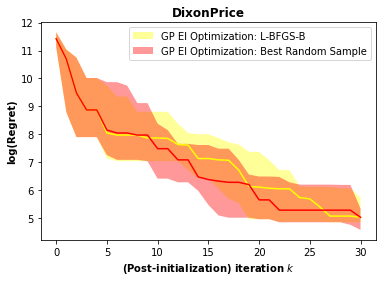

In [108]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: L-BFGS-B')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Best Random Sample')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(0, count, 5))
plt.show() #visualise!

In [109]:
time_approx, time_exact


(411.7489404678345, 118.60589098930359)